# Development of machine learning models to process Electronic Health Records – Explainable Models

### Preprocessing Notebook
Lok Hang Toby Lee (2431180L)

### Configuration Step
1. Imports
2. Set database configurations
3. Connect to MIMIC-III local postgreSQL database

In [9]:
# Imports:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys
import psycopg2
import os
import yaml
%matplotlib inline


#pg_ctl.exe restart -D "E:\PostgreSQL\data"

# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'public, mimic, mimiciii;'

# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

### Study cohort selection
- Only first ICU admissions that took at least a day and less than 10 days
- Adult patients only (age >= 15)

In [2]:
# Settings for the query:
min_age = 15
limit_population = 0 # if we want to run the query for a small number of patients (for debugging)
if limit_population > 0:
    limit = 'LIMIT ' + str(limit_population)
else:
    limit = ''
    
query = """
with patient_and_icustay_details as (
    SELECT distinct
        p.gender, p.dob, p.dod, s.*, a.admittime, a.dischtime, a.deathtime, a.ethnicity, a.diagnosis, a.hospital_expire_flag,
        DENSE_RANK() OVER (PARTITION BY a.subject_id ORDER BY a.admittime) AS hospstay_seq,
        round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hospital_los,
        DENSE_RANK() OVER (PARTITION BY s.hadm_id ORDER BY s.intime) AS icustay_seq,
        DATE_PART('year', s.intime) - DATE_PART('year', p.dob) as admission_age,
        DATE_PART('day', s.outtime - s.intime) as los_icu
    FROM patients p 
        INNER JOIN icustays s ON p.subject_id = s.subject_id
        INNER JOIN admissions a ON s.hadm_id = a.hadm_id 
    WHERE s.first_careunit NOT like 'NICU'
        and s.hadm_id is not null and s.icustay_id is not null
        and (s.outtime >= (s.intime + interval '12 hours'))
        and (s.outtime <= (s.intime + interval '240 hours'))
    ORDER BY s.subject_id 
)
SELECT * 
FROM patient_and_icustay_details 
WHERE hospstay_seq = 1
    and icustay_seq = 1
    and admission_age >=  """ + str(min_age) + """
    and los_icu >= 0.5
""" + str(limit)
patients_data = pd.read_sql_query('SET search_path to ' + schema_name + query, con)

# Save result:
patients_data.to_csv('static_data.csv')

NameError: name 'pd' is not defined

In [3]:
patients_data = pd.read_csv('static_data.csv')  
patients_data.columns

Index(['Unnamed: 0', 'gender', 'dob', 'dod', 'row_id', 'subject_id', 'hadm_id',
       'icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime', 'los', 'admittime',
       'dischtime', 'deathtime', 'ethnicity', 'diagnosis',
       'hospital_expire_flag', 'hospstay_seq', 'hospital_los', 'icustay_seq',
       'admission_age', 'los_icu'],
      dtype='object')

In [4]:
patients_data

,Unnamed: 0,gender,dob,dod,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,...,dischtime,deathtime,ethnicity,diagnosis,hospital_expire_flag,hospstay_seq,hospital_los,icustay_seq,admission_age,los_icu
0,0,M,2025-04-11 00:00:00,2102-06-14 00:00:00,2,3,145834,211552,carevue,MICU,...,2101-10-31 13:58:00,NaN,WHITE,HYPOTENSION,0,1,10.7847,1,76.0,6.0
1,1,F,2143-05-12 00:00:00,NaN,3,4,185777,294638,carevue,MICU,...,2191-03-23 18:41:00,NaN,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,7.7590,1,48.0,1.0
2,2,F,2109-06-21 00:00:00,NaN,5,6,107064,228232,carevue,SICU,...,2175-06-15 16:00:00,NaN,WHITE,CHRONIC RENAL FAILURE/SDA,0,1,16.3646,1,66.0,3.0
3,3,M,2108-01-26 00:00:00,2149-11-14 00:00:00,9,9,150750,220597,carevue,MICU,...,2149-11-14 10:15:00,2149-11-14 10:15:00,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,1,1,4.8813,1,41.0,5.0
4,4,F,2128-02-22 00:00:00,2178-11-14 00:00:00,11,11,194540,229441,carevue,SICU,...,2178-05-11 19:00:00,NaN,WHITE,BRAIN MASS,0,1,25.5292,1,50.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30058,30058,M,2114-09-29 00:00:00,NaN,61527,99983,117390,286606,metavision,CCU,...,2193-04-29 13:30:00,NaN,UNKNOWN/NOT SPECIFIED,ST ELEVATION MYOCARDIAL INFARCTION;CORONARY AR...,0,1,3.0799,1,79.0,1.0
30059,30059,M,2137-04-07 00:00:00,NaN,61529,99991,151118,226241,metavision,TSICU,...,2185-01-05 12:15:00,NaN,WHITE,DIVERTICULITIS/SDA,0,1,12.1563,1,47.0,3.0
30060,30060,F,2078-10-17 00:00:00,NaN,61530,99992,197084,242052,metavision,MICU,...,2144-07-28 17:56:00,NaN,WHITE,RETROPERITONEAL HEMORRHAGE,0,1,2.9951,1,66.0,1.0
30061,30061,F,2058-05-29 00:00:00,2147-09-29 00:00:00,61531,99995,137810,229633,metavision,CSRU,...,2147-02-11 13:15:00,NaN,WHITE,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,3.2188,1,89.0,2.0


### Extract length of stay and in-hospital mortality

In [5]:
outcomes = pd.DataFrame(index=patients_data.index)
# In hospital mortality: patient has died after the admittime to hospital and before the outtime:
mortality = patients_data.dod.notnull() & ((patients_data.admittime <= patients_data.dod) & (patients_data.outtime >= patients_data.dod))
mortality = mortality | (patients_data.deathtime.notnull() & ((patients_data.admittime <= patients_data.deathtime) & 
                                                             (patients_data.dischtime >= patients_data.deathtime)))
outcomes['in_hospital_mortality'] = mortality.astype(int)
patients_data['in_hospital_mortality'] = mortality.astype(int)
# Length of stay (in hours):
outcomes['los'] = patients_data['los'] * 24.0
outcomes.to_hdf('vitals_hourly_data.h5', 'Y')

In [6]:
outcomes

,in_hospital_mortality,los
0,0,145.5504
1,0,40.2840
2,0,88.1496
3,1,127.7544
4,0,38.0256
...,...,...
30058,0,24.9576
30059,0,75.4224
30060,0,47.3880
30061,0,51.8760


### Machine Learning Base model

Logistic Regression: 0.9043738566439381
Accuracy  : 0.9043738566439381
Precision : 0.7023888796404195
Recall : 0.502332858947503
f1score macro : 0.4800433713885687
f1score micro : 0.904373856643938
AdaBoost Classifier: 0.9060369200066523
Accuracy  : 0.9060369200066523
Precision : 0.7407033484772001
Recall : 0.5320242416489438
f1score macro : 0.5371934320017927
f1score micro : 0.9060369200066523
Random Forest: 0.8985531348744387
Accuracy  : 0.8985531348744387
Precision : 0.6941692270139879
Recall : 0.6429743991556999
f1score macro : 0.6630425596025517
f1score micro : 0.8985531348744387


Text(0.5, 1.0, 'ROC curves for in-hospital mortality')

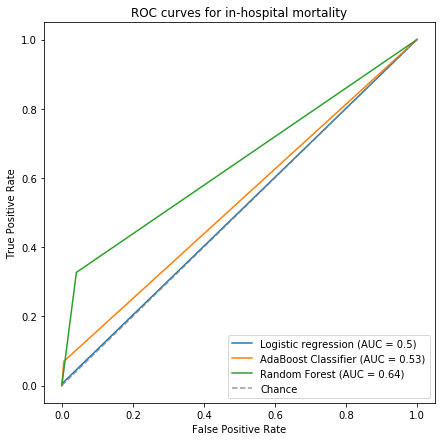

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn
from sklearn.metrics import roc_auc_score, roc_curve

def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score_macro = f1_score(test, pred, average='macro') 
    f1score_micro = f1_score(test, pred, average='micro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score macro : {}".format(f1score_macro))
    print("f1score micro : {}".format(f1score_micro))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    # return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score_macro,3), 
    #         round(f1score_micro, 3), cm)

df_train, df_test = train_test_split(patients_data, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 100)

numeric_vars = ['hospital_los','admission_age','los_icu']

x_train = df_train[numeric_vars].to_numpy()
y_train = df_train['in_hospital_mortality']


x_test = df_test[numeric_vars]
y_test = df_test['in_hospital_mortality']



lg = LogisticRegression(penalty = 'l2', C = 1, random_state = 0, solver='lbfgs')
lg.fit(x_train, y_train)
print("Logistic Regression:", lg.score(x_test,y_test))
lg_predction = lg.predict(x_test)
showResults(y_test,lg_predction,lg)

adb = AdaBoostClassifier()
adb.fit(x_train, y_train)
print("AdaBoost Classifier:", adb.score(x_test,y_test))
adb_predction = adb.predict(x_test)

showResults(y_test,adb_predction,adb)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train,y_train)
rf_predction = rf.predict(x_test)
print("Random Forest:" , rf.score(x_test,y_test))
showResults(y_test,rf_predction,rf)

# ROC AUC curve:
roc_auc_logreg = roc_auc_score(y_test, lg_predction)
fpr_logreg, tpr_logreg, threshold_logreg = roc_curve(y_test, lg_predction)

roc_auc_adb = roc_auc_score(y_test, adb_predction)
fpr_adb, tpr_adb, threshold_adb = roc_curve(y_test, adb_predction)

roc_auc_rf = roc_auc_score(y_test, rf_predction)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, rf_predction)

fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(fpr_logreg, tpr_logreg, label = 'Logistic regression (AUC = ' + str(round(roc_auc_logreg, 2)) + ')')
ax.plot(fpr_adb, tpr_adb, label = 'AdaBoost Classifier (AUC = ' + str(round(roc_auc_adb, 2)) + ')')
ax.plot(fpr_rf, tpr_rf, label = 'Random Forest (AUC = ' + str(round(roc_auc_rf, 2)) + ')')
ax.plot([0, 1], [0, 1], linestyle='--', color = 'gray', label = 'Chance', alpha=0.8)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for in-hospital mortality')




Text(667.6588235294118, 0.5, 'True label')

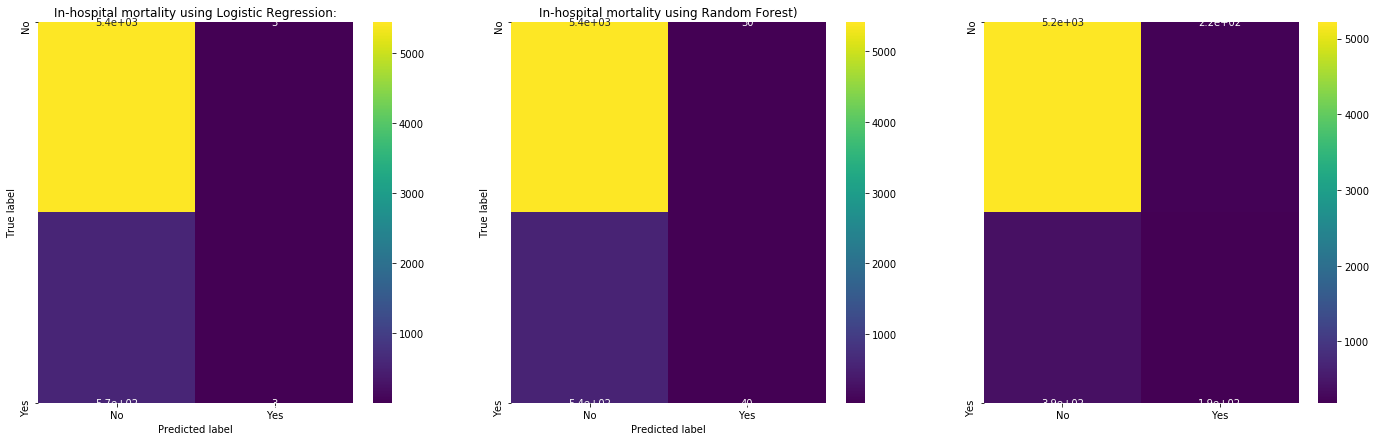

In [30]:
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(1, 3, figsize=(24, 7))

# Confusion matrix for the baseline model:
cm = confusion_matrix(y_test, lg_predction)
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[0])
ax[0].set_title('In-hospital mortality using Logistic Regression:')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

# Confusion matrix for the baseline model:
cm1 = confusion_matrix(y_test,adb_predction) 
df_cf = pd.DataFrame(np.round(cm1, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[1])
ax[1].set_title('In-hospital mortality using AdaBoost Classifier)')
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')

# Confusion matrix for the baseline model:
cm2 = confusion_matrix(y_test,rf_predction) 
df_cf = pd.DataFrame(np.round(cm2, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[2])
ax[1].set_title('In-hospital mortality using Random Forest)')
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')